Class Distribution:
 sus_res
sus    10
res     9
Name: count, dtype: int64


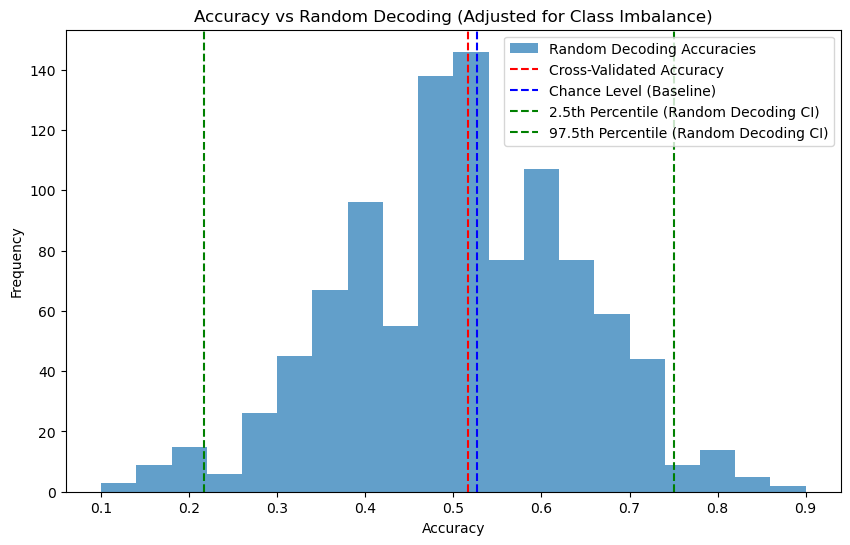

{'Cross-Validated Accuracy (Mean)': 0.5166666666666667, 'Cross-Validated Accuracy (Std)': 0.13333333333333336, 'Chance Level (Majority Class)': 0.5263157894736842, 'Random Decoding CI (2.5th Percentile)': 0.21666666666666665, 'Random Decoding CI (97.5th Percentile)': 0.75}


In [ ]:
# Re-import necessary libraries and start fresh
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import joblib

# File path
file_path = r"C:\Users\Paula Woest\OneDrive\Desktop\Bachelore Arbeit\Paula\output_data\all_data_feature_matrix_session2.csv"
# file_path = r"C:\Users\samih\Desktop\final_feature_matrix_session2.csv"

try:
    # Load the data
    data = pd.read_csv(file_path)
    
    # Remove rows with NaN in the sus_res column
    data = data.dropna(subset=['sus_res'])
    data['sus_res'] = data['sus_res'].str.strip()

    # Prepare the data
    # Drop mouse_ID column and separate features and labels
    data = data.drop(columns=['mouse_ID'], errors='ignore')
    X = data.drop(columns=['sus_res'], errors='ignore')
    y = data['sus_res']

    # Check class distribution
    class_counts = y.value_counts()
    print("Class Distribution:\n", class_counts)

    # Handle rare classes (if necessary)
    min_samples_threshold = 2  # Minimum samples required per class
    if class_counts.min() < min_samples_threshold:
        rare_classes = class_counts[class_counts < min_samples_threshold].index
        print(f"Removing classes with fewer than {min_samples_threshold} samples: {rare_classes.tolist()}")
        data = data[~data['sus_res'].isin(rare_classes)]
        X = data.drop(columns=['sus_res'], errors='ignore')
        y = data['sus_res']

    # Define the Linear SVM model
    model = SVC(kernel='linear', C=1)
    # model = SVC(kernel='rbf')

    # Stratified cross-validation to handle class imbalance
    stratified_cv = StratifiedKFold(n_splits=5)

    # Compute cross-validated accuracy with StratifiedKFold
    cross_val_scores = cross_val_score(model, X, y, cv=stratified_cv)
    best_model = model.fit(X, y)  # Save the best model trained on the entire dataset
    joblib.dump(best_model, "best_svm_model.pkl")  # Save the model to disk

    # Update chance level after adjustments
    class_distribution = y.value_counts(normalize=True)
    chance_level = class_distribution.max()

    # Perform random decoding 1000 times with adjusted data
    random_decoding_accuracies = []
    for _ in range(1000):
        y_shuffled = shuffle(y, random_state=_)
        random_scores = cross_val_score(model, X, y_shuffled, cv=stratified_cv, scoring='accuracy')
        random_decoding_accuracies.append(np.mean(random_scores))

    # Calculate 2.5th and 97.5th percentiles for CI
    ci_2_5 = np.percentile(random_decoding_accuracies, 2.5)
    ci_97_5 = np.percentile(random_decoding_accuracies, 97.5)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.hist(random_decoding_accuracies, bins=20, alpha=0.7, label='Random Decoding Accuracies')
    plt.axvline(np.mean(cross_val_scores), color='r', linestyle='--', label='Cross-Validated Accuracy')
    plt.axvline(chance_level, color='b', linestyle='--', label='Chance Level (Baseline)')
    plt.axvline(ci_2_5, color='g', linestyle='--', label='2.5th Percentile (Random Decoding CI)')
    plt.axvline(ci_97_5, color='g', linestyle='--', label='97.5th Percentile (Random Decoding CI)')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title('Accuracy vs Random Decoding (Adjusted for Class Imbalance)')
    plt.legend()
    plt.show()

    # Print final results
    results = {
        "Cross-Validated Accuracy (Mean)": np.mean(cross_val_scores),
        "Cross-Validated Accuracy (Std)": np.std(cross_val_scores),
        "Chance Level (Majority Class)": chance_level,
        "Random Decoding CI (2.5th Percentile)": ci_2_5,
        "Random Decoding CI (97.5th Percentile)": ci_97_5
    }
    print(results)
    
except FileNotFoundError:
    print(f"File not found: {file_path}. Please check the file path or upload the file.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Get weight vector and labels from the best model
try:
    # Retrieve weight vector and feature names
    weight_vector = best_model.coef_[0]  # For binary classification
    feature_names = X.columns
    labels = best_model.classes_

    # Create a DataFrame for better readability
    weight_df = pd.DataFrame({
        "Feature": feature_names,
        "Weight": weight_vector
    })

    # Print weight vector with corresponding features and class labels
    print("\nWeight vector with feature names:")
    print(weight_df)

    # Output labels for reference
    print("\nClass labels:")
    print(labels)

except AttributeError:
    print("The model does not have weight vectors. Ensure it is logistic regression or SVM with a linear kernel.")
except Exception as e:
    print(f"An error occurred: {e}")


Weight vector with feature names:
                      Feature    Weight
0        mean_location_Neck.x -0.014997
1        mean_location_Neck.y  0.029495
2                    s_in_roi -0.075637
3            s_in_roi_ang_dir -0.176315
4                  mean_angle  0.261990
5  mean_distance_nose_to_tail -0.011794
6             mean_distance_x -0.069442
7             mean_distance_y  0.459087
8                median_speed  0.371146
9                   iqr_speed  0.472839

Class labels:
['res' 'sus']
